In [1]:
import os
import cv2
from tqdm import tqdm
from random import sample
from PIL import Image
import pickle
import time
import sys

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset

from sklearn.metrics import accuracy_score
from sklearn import svm, metrics, preprocessing

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install timm==0.4.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.6.13
    Uninstalling timm-0.6.13:
      Successfully uninstalled timm-0.6.13


In [3]:
with open(r"/kaggle/input/dgw-faces-annotation/dgw_train_faces_annotation", "rb") as input_file:
    train_annotation = pickle.load(input_file)
    
with open(r"/kaggle/input/dgw-faces-annotation/dgw_val_faces_annotation", "rb") as input_file:
    val_annotation = pickle.load(input_file)
    
with open(r"/kaggle/input/dgw-faces-annotation/dgw_test_faces_annotation", "rb") as input_file:
    test_annotation = pickle.load(input_file)

In [5]:
train_annotation[train_annotation['Кадр'].apply(lambda x: x.split('/')[-1].split('.')[0]) == list(os.listdir('/kaggle/input/dgw-eyes/train_eyes/train_eyes/left'))[200].split('.')[0]]

,Кадр,Класс,Субъект
8205,/kaggle/input/driver-gaze-in-the-wild/dgw_face...,7,39


In [6]:
list(os.listdir('/kaggle/input/dgw-eyes/train_eyes/train_eyes/left'))[0]

'Video19_sub33_frame418.jpg'

In [4]:
class DriverEye(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.annotation = annotation_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_names = list(os.listdir(self.img_dir))

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        eye_img_name = self.img_names[idx]
        annotation_row = self.annotation[self.annotation['Кадр'].apply(lambda x: x.split('/')[-1].split('.')[0]) == eye_img_name.split('.')[0]]
        eye_img_path = self.img_dir + '/' + eye_img_name
        
        if os.path.exists(eye_img_path):
            eye = cv2.imread(eye_img_path, cv2.IMREAD_COLOR)
            label = annotation_row.iloc[0, 1]
        
            if self.transform:
                eye = self.transform(eye)
            if self.target_transform:
                label = self.target_transform(label)
                
            return eye, int(label)

In [8]:
train_annotation['Кадр'][0]

'/kaggle/input/driver-gaze-in-the-wild/dgw_faces/dgw_faces/train_faces/7/Sub56_vid1_frame186.png'

In [5]:
eye_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     # torchvision.transforms.Grayscale(),
     torchvision.transforms.Resize((224, 224), antialias=True),
     torchvision.transforms.RandomHorizontalFlip(p=1)])

In [10]:
train_left_eyes = DriverEye(train_annotation, '/kaggle/input/dgw-eyes/train_eyes/train_eyes/left', eye_transform)
val_left_eyes = DriverEye(val_annotation, '/kaggle/input/dgw-eyes/val_eyes/val_eyes/left', eye_transform)
test_left_eyes = DriverEye(test_annotation, '/kaggle/input/dgw-eyes/test_eyes/test_eyes/left', eye_transform)

In [11]:
len(train_left_eyes)

21289

torch.Size([3, 224, 224])
8


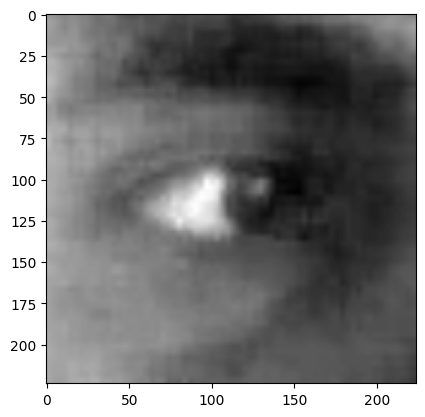

In [12]:
figure = plt.figure()

sample_idx = torch.randint(len(train_left_eyes), size=(1,)).item()
img, label = train_left_eyes[sample_idx]
print(img.shape)
print(label)
plt.imshow(img[0], cmap="gray")
plt.show()

In [13]:
train_left_eye_loader = torch.utils.data.DataLoader(train_left_eyes, batch_size = 64, num_workers=2, shuffle = True)
val_left_eye_loader = torch.utils.data.DataLoader(val_left_eyes, batch_size = 64, num_workers=2, shuffle = False)
test_left_eye_loader = torch.utils.data.DataLoader(test_left_eyes, batch_size = 64, num_workers=2, shuffle = False)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


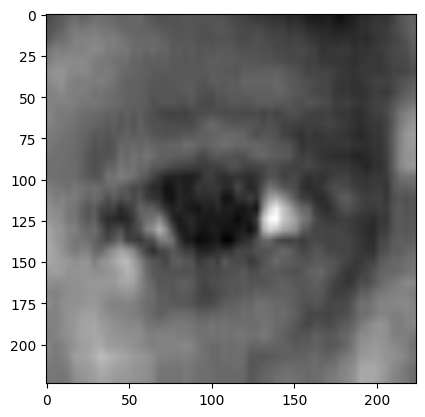

Label: 2


In [14]:
train_left_eye_loader_iter = iter(train_left_eye_loader)
train_features, train_labels = next(train_left_eye_loader_iter)
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

In [7]:
target = ['левая верхняя часть лобового стекла','прямо перед собой','спидометр', 'радио',
            'правая верхняя часть лобового стекла','правая нижняя часть лобового стекла', 
            'правое боковое зеркало', 'зеркало заднего вида', 'левое боковое зеркало',
         ]

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
    logger = None,
    cur_epoch = None
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    N = len(data_loader)
    with tqdm(total=N, file=sys.stdout) as prbar:
        for iter, (images, labels) in enumerate(data_loader):
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            # print(predicted)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            '''prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )'''
            prbar.update(1)

            if logger is not None:
                logger.add_scalar('Train/loss', loss, cur_epoch*N + iter)
                logger.add_scalar('Train/accuracy', accuracy, cur_epoch*N + iter)

            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    # print(total_loss, num_batches)
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    # print((total_predictions == total_labels).mean())
    
    print(
        f"Loss: {round(metrics['loss'], 4)} "
        f"Accuracy: {round(metrics['accuracy'] * 100, 4)}"
    )
    
    if return_losses:
        return metrics, all_losses
    else:
        return metrics

In [9]:
def validate(model, data_loader, criterion, device="cuda:0", logger=None, cur_epoch=None):
    model = model.to(device).eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    N = len(data_loader)
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for iter, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            # prbar.set_description(
            #     f"Loss: {round(loss.item(), 4)} "
            #     f"Accuracy: {round(accuracy.item() * 100, 4)}"
            # )
            prbar.update(1)

            '''if logger is not None:
                logger.add_scalar('Train/loss', loss, cur_epoch*N + iter)
                logger.add_scalar('Train/accuracy', accuracy, cur_epoch*N + iter)'''
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    # print(total_loss, num_batches)    
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})

    print(
        f"Loss: {round(metrics['loss'], 4)} "
        f"Accuracy: {round(metrics['accuracy'] * 100, 4)}"
    )
    return metrics

In [10]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion,
    device="cuda:0",
    log_dir=None
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []

    if log_dir is not None:
        writer = SummaryWriter(log_dir=log_dir)
    else:
        writer = None

    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
            device=device,
            logger = writer,
            cur_epoch = epoch
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion,
                logger = writer,
                cur_epoch = epoch
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])

In [11]:
def test(model, data_loader, criterion, device="cuda:0", logger=None, cur_epoch=None):
    model = model.to(device).eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    total_predicted_probs = np.array([])
    N = len(data_loader)
    
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for iter, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            prbar.update(1)

            '''if logger is not None:
                logger.add_scalar('Train/loss', loss, cur_epoch*N + iter)
                logger.add_scalar('Train/accuracy', accuracy, cur_epoch*N + iter)'''
            total_loss += loss.item()
            total_predicted_probs = np.append(total_predicted_probs, predicted.cpu().detach().numpy())
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
        
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    
    # cl_report = classification_report(total_predictions, total_labels)
    
    print(
        f"Loss: {round(metrics['loss'], 4)} "
        f"Accuracy: {round(metrics['accuracy'] * 100, 4)}"
    )
    return metrics, total_predictions, total_labels, total_predicted_probs

In [28]:
enet_path = '/kaggle/input/emotion-recognition-model/enet_b0_8.pt'
model = torch.load(enet_path)

In [29]:
model.classifier[0] = nn.Linear(1280, 9)

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003)

In [31]:
num_epoch = 1
start = time.time()

fit(model, num_epoch, train_left_eye_loader, val_left_eye_loader, optimizer, criterion, device=device)
print('Время с batch_size = 64: ', time.time() - start)

Train Epoch: 0
100%|██████████| 333/333 [07:47<00:00,  1.40s/it]
Loss: 0.9567 Accuracy: 65.9214
Validation Epoch: 0
100%|██████████| 153/153 [01:47<00:00,  1.42it/s]
Loss: 1.4661 Accuracy: 54.4839
Время с batch_size = 64:  574.895426273346


In [32]:
torch.save(model.state_dict(), '/kaggle/working/enet_left_eye.h5')

In [40]:
with torch.no_grad():
    test_metrics, y_pred, y_true, pred_probs = test(
        model=model,
        data_loader=test_left_eye_loader,
        criterion=criterion
    )

100%|██████████| 118/118 [01:09<00:00,  1.69it/s]
Loss: 1.4106 Accuracy: 53.2791


In [44]:
with open(r'/kaggle/working/enet_left_eye_probs', 'wb') as handle:
    pickle.dump(pred_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(r'/kaggle/working/enet_left_eye_pred', 'wb') as handle:
    pickle.dump(y_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
confusion = pd.crosstab(y_true, y_pred, rownames=['y_true'], colnames=['y_pred'])
confusion.columns = target
confusion.index = target

<AxesSubplot: title={'center': 'Confusion matrix'}>

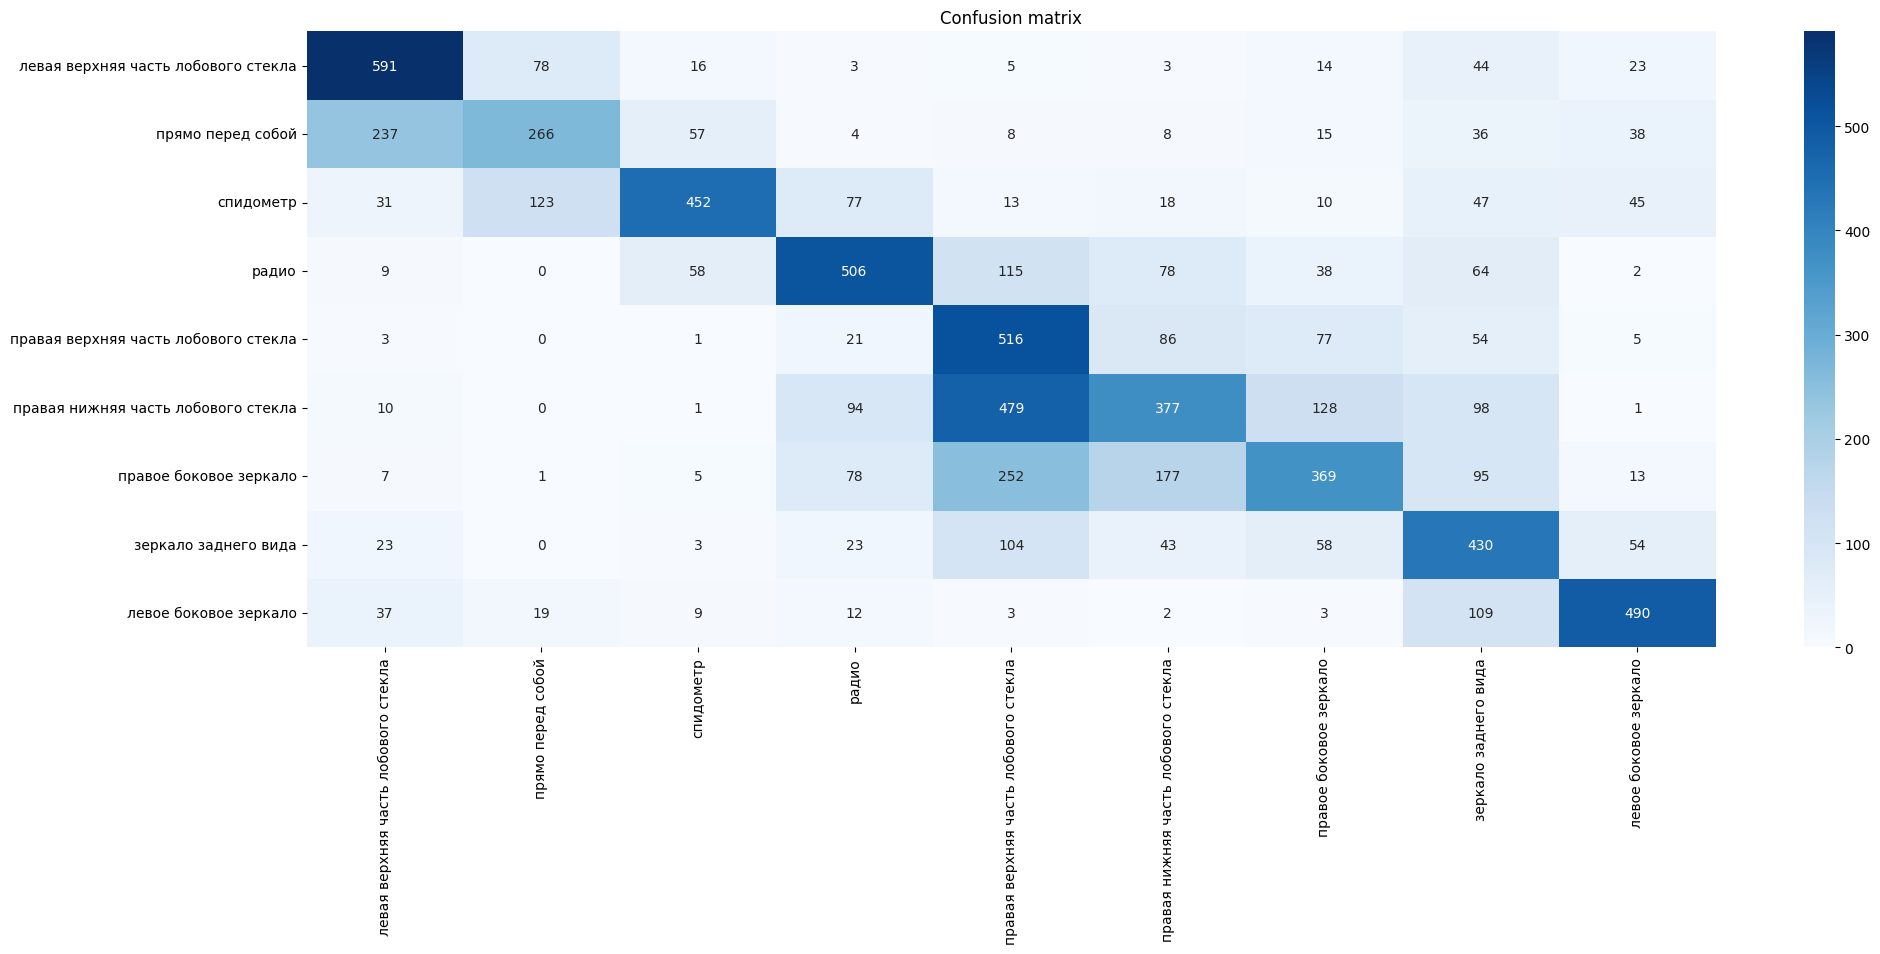

In [43]:
fig = plt.figure(figsize=(50,8))
# plt.subplot(121, xlabel='y_true')
ax1 = fig.add_subplot(121)
ax1.set_title('Confusion matrix')
# sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')

### Right Eye

In [12]:
train_right_eyes = DriverEye(train_annotation, '/kaggle/input/dgw-eyes/train_eyes/train_eyes/right', eye_transform)
val_right_eyes = DriverEye(val_annotation, '/kaggle/input/dgw-eyes/val_eyes/val_eyes/right', eye_transform)
test_right_eyes = DriverEye(test_annotation, '/kaggle/input/dgw-eyes/test_eyes/test_eyes/right', eye_transform)

In [13]:
train_right_eye_loader = torch.utils.data.DataLoader(train_right_eyes, batch_size = 64, num_workers=2, shuffle = True)
val_right_eye_loader = torch.utils.data.DataLoader(val_right_eyes, batch_size = 64, num_workers=2, shuffle = False)
test_right_eye_loader = torch.utils.data.DataLoader(test_right_eyes, batch_size = 64, num_workers=2, shuffle = False)

In [18]:
enet_path = '/kaggle/input/emotion-recognition-model/enet_b0_8.pt'
model = torch.load(enet_path, map_location=torch.device('cpu'))

In [19]:
model.classifier[0] = nn.Linear(1280, 9)

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0002)

In [21]:
num_epoch = 1
start = time.time()

fit(model, num_epoch, train_right_eye_loader, val_right_eye_loader, optimizer, criterion, device=device)
print('Время с batch_size = 64: ', time.time() - start)

Train Epoch: 0
100%|██████████| 333/333 [07:29<00:00,  1.35s/it]
Loss: 1.0591 Accuracy: 62.7272
Validation Epoch: 0
100%|██████████| 153/153 [01:43<00:00,  1.48it/s]
Loss: 1.4009 Accuracy: 54.9148
Время с batch_size = 64:  552.3407440185547


In [22]:
with torch.no_grad():
    test_metrics, y_pred, y_true, pred_probs = test(
        model=model,
        data_loader=test_right_eye_loader,
        criterion=criterion
    )

100%|██████████| 118/118 [01:14<00:00,  1.58it/s]
Loss: 1.3844 Accuracy: 55.8251


In [23]:
with open(r'/kaggle/working/enet_right_eye_probs', 'wb') as handle:
    pickle.dump(pred_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(r'/kaggle/working/enet_right_eye_pred', 'wb') as handle:
    pickle.dump(y_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(r'/kaggle/working/enet_right_eye_y_true', 'wb') as handle:
    pickle.dump(y_true, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
torch.save(model.state_dict(), '/kaggle/working/enet_right_eye.h5')